<a href="https://colab.research.google.com/github/georgesteve/Research-Assitant-ML-ROJ/blob/main/Semana_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#[Forecasting Global Ionospheric TEC Using Deep Learning Approach](https://doi.org/10.1029/2020SW002501)

https://www.tensorflow.org/tutorials/structured_data/time_series#multi-step_models

In [5]:
import tensorflow as tf
tf.test.gpu_device_name()

''

In [ ]:
# Mount Google Drive
from google.colab import drive # import drive from google colab

ROOT = "/content/drive"     # default location for the drive
print(ROOT)                 # print content of ROOT (Optional)

drive.mount(ROOT)           # we mount the google drive at /content/drive

/content/drive


KeyboardInterrupt: ignored

Este paper utiliza RNN con arquitecturas LSTM para predecir condiciones de TEC.


##Importar librerías

In [6]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
print(tf.__version__)

2.5.0


In [ ]:
https://github.com/georgesteve/Research-Assitant-ML-ROJ.git

##Importar Data

In [7]:

URL = "https://raw.githubusercontent.com/georgesteve/Research-Assitant-ML-ROJ/main/gfajardo_uNz2xU-2020-2.csv"
Data = pd.read_csv(URL,index_col=False) 
df=Data.drop(columns=['Unnamed: 0'])


In [8]:
#print(df)
df.describe()

,Año,Day,Tiempo,PRN,S4,Az,Elv
count,452987.0,452987.000000,452987.000000,452987.000000,452987.000000,452987.000000,452987.000000
mean,20.0,321.407877,42575.907313,28.850960,0.099181,190.824284,37.057117
std,0.0,9.239411,25046.073519,37.546005,0.075309,102.558542,17.537060
min,20.0,306.000000,22.000000,1.000000,0.020000,0.000000,0.000000
25%,20.0,313.000000,20182.000000,9.000000,0.050000,111.800000,22.000000
50%,20.0,321.000000,42382.000000,19.000000,0.070000,201.500000,35.800000
75%,20.0,329.000000,64822.000000,27.000000,0.120000,288.400000,50.500000
max,20.0,337.000000,85540.000000,138.000000,1.140000,360.000000,89.000000


Transformando el tiempo a formato date time

In [9]:
df['date_time'] = pd.to_datetime(df['Año']*1000+df['Day'], format='%y%j')+pd.Series([pd.Timedelta(seconds=x) for x in df['Tiempo']])
print(df['date_time'])

0        2020-11-01 00:00:22
1        2020-11-01 00:00:22
2        2020-11-01 00:00:22
3        2020-11-01 00:00:22
4        2020-11-01 00:00:22
                 ...        
452982   2020-12-02 23:45:40
452983   2020-12-02 23:45:40
452984   2020-12-02 23:45:40
452985   2020-12-02 23:45:40
452986   2020-12-02 23:45:40
Name: date_time, Length: 452987, dtype: datetime64[ns]


In [10]:
df=df.drop(['Año',	'Day',	'Tiempo'], axis=1)
df.head()

,PRN,S4,Az,Elv,date_time
0,3,0.10,300.9,24.6,2020-11-01 00:00:22
1,8,0.05,199.5,47.2,2020-11-01 00:00:22
2,10,0.40,147.1,14.3,2020-11-01 00:00:22
3,11,0.08,210.6,26.2,2020-11-01 00:00:22
4,16,0.04,342.4,42.3,2020-11-01 00:00:22


Evolución de algunas características a lo largo del tiempo.

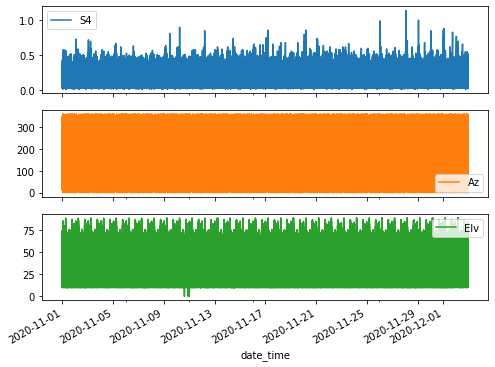

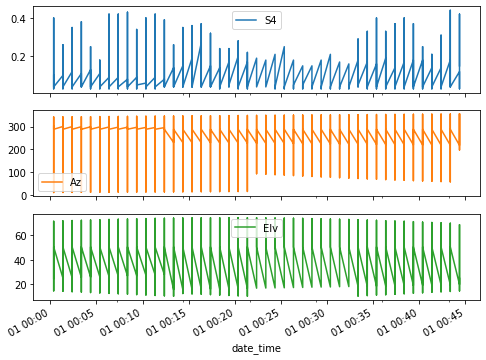

In [11]:
plot_cols = ['S4', 'Az', 'Elv']
plot_features = df[plot_cols]
plot_features.index = df['date_time']
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = df['date_time'][:480]
_ = plot_features.plot(subplots=True)

##Analizar para limpieza

In [12]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
PRN,452987.0,28.850960,37.546005,1.00,9.00,19.00,27.00,138.00
S4,452987.0,0.099181,0.075309,0.02,0.05,0.07,0.12,1.14
Az,452987.0,190.824284,102.558542,0.00,111.80,201.50,288.40,360.00
Elv,452987.0,37.057117,17.537060,0.00,22.00,35.80,50.50,89.00


Text(0.5, 0, 'Az')

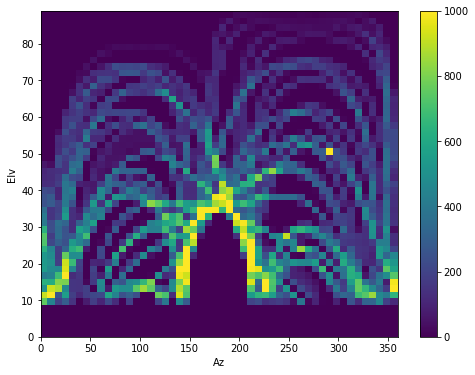

In [13]:
plt.hist2d( df['Az'],df['Elv'], bins=(50, 50), vmax=1000)
plt.colorbar()
plt.ylabel('Elv')
plt.xlabel('Az')

In [14]:
# Convert to radians.
az_rad = df.pop('Az')*np.pi / 180

# Calculate the wind x and y components.
az_x = np.cos(az_rad)
az_y = np.sin(az_rad)

elv_rad = 1-np.sin(df.pop('Elv')*np.pi / 180)


df['Pro-x']=az_x *elv_rad
df['Pro-y']=az_y *elv_rad


# Calculate the max wind x and y components.
#df['max Wx'] = max_wv*np.cos(wd_rad)
#df['max Wy'] = max_wv*np.sin(wd_rad)

(-0.6871165997871423, 1.0, -0.8256861092678117, 0.8265263805716255)

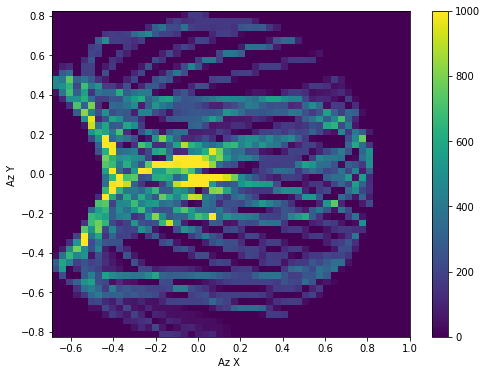

In [15]:
plt.hist2d(df['Pro-x'], df['Pro-y'], bins=(50, 50), vmax=1000)
plt.colorbar()
plt.xlabel('Az X ')
plt.ylabel('Az Y ')
ax = plt.gca()
ax.axis('tight')

Extrayendo características cíclicas de tiempo

In [20]:
timestamp_s = df['date_time'].map(datetime.datetime.timestamp)
print(timestamp_s)

0         1.604189e+09
1         1.604189e+09
2         1.604189e+09
3         1.604189e+09
4         1.604189e+09
              ...     
452982    1.606953e+09
452983    1.606953e+09
452984    1.606953e+09
452985    1.606953e+09
452986    1.606953e+09
Name: date_time, Length: 452987, dtype: float64


In [21]:
timestamp_s = df['date_time'].map(datetime.datetime.timestamp)


day = 24*60*60

year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

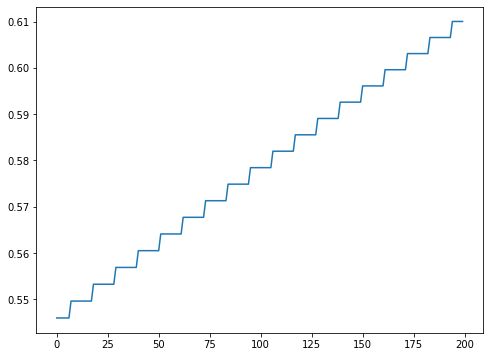

In [34]:
plt.plot(np.array(df['Day sin'])[24*60*1:24*60*1+200])

Text(0.5, 1.0, 'Comportamiento de la señal')

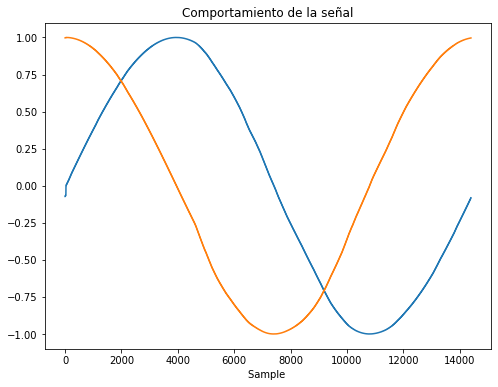

In [35]:
#Aparentemente se registran unos 10 a 11 satélites en cada obsrevación
plt.plot(np.array(df['Day sin'])[24*60*30:24*60*40]) #Segundos diarios=24*60*60, Frecuencia de muestreo=10s->Limite diario=24*60*10
plt.plot(np.array(df['Day cos'])[24*60*30:24*60*40])
plt.xlabel('Sample ')
plt.title('Comportamiento de la señal')

1604447002.0
1604447062.0
1604447122.0
1604533282.0


Text(0.5, 1.0, 'Time of day signal')

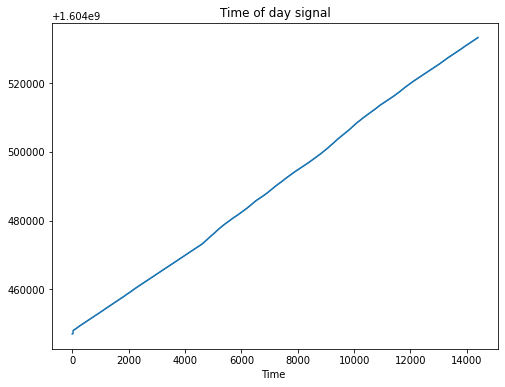

In [36]:
plt.plot(np.array(df['date_time'].map(datetime.datetime.timestamp)[24*60*30:24*60*40])) #Segundos diarios=24*60*60, Frecuencia de muestreo=10s->Limite diario=24*60*10
print(df['date_time'].map(datetime.datetime.timestamp)[24*60*30])
print(df['date_time'].map(datetime.datetime.timestamp)[24*60*30+10])
print(df['date_time'].map(datetime.datetime.timestamp)[24*60*30+20])
print(df['date_time'].map(datetime.datetime.timestamp)[24*60*40])
plt.xlabel('Time ')
plt.title('Time of day signal')

Esto le da al modelo acceso a las características de frecuencia más importantes. En este caso, sabía de antemano qué frecuencias eran importantes.

Si no lo sabía, puede determinar qué frecuencias son importantes usando un fft . Para comprobar nuestras suposiciones, aquí está el tf.signal.rfft de la temperatura a lo largo del tiempo. Tenga en cuenta los picos obvios en frecuencias cercanas a 1/year y 1/day

In [38]:
#Este cpodigo aún debe ser adaptdo, en este punto existen "n" muestras para cada observación, además "n" es variable



###Adaptación->>>Generar un promedio por cada observación o seleccionar el máximo
df_idx = df.set_index('date_time')

df_max=df_idx.resample('5min').max()
print(df_max)

                       PRN    S4     Pro-x  ...   Day cos  Year sin  Year cos
date_time                                   ...                              
2020-11-01 00:00:00  138.0  0.40  0.718923  ...  0.999999 -0.861612  0.507568
2020-11-01 00:05:00  138.0  0.43  0.744197  ...  0.999726 -0.861581  0.507619
2020-11-01 00:10:00  138.0  0.42  0.767236  ...  0.998977 -0.861551  0.507671
2020-11-01 00:15:00  138.0  0.37  0.789529  ...  0.997753 -0.861521  0.507722
2020-11-01 00:20:00  138.0  0.28  0.797954  ...  0.996054 -0.861490  0.507774
...                    ...   ...       ...  ...       ...       ...       ...
2020-12-02 23:25:00  138.0  0.40  0.360179  ...  0.991254 -0.469180  0.883102
2020-12-02 23:30:00  138.0  0.52  0.329802  ...  0.993897 -0.469127  0.883131
2020-12-02 23:35:00  138.0  0.39  0.331272  ...  0.996067 -0.469075  0.883159
2020-12-02 23:40:00  138.0  0.25  0.683199  ...  0.997763 -0.469022  0.883187
2020-12-02 23:45:00  138.0  0.28  0.676698  ...  0.998045 -0.469

In [47]:
print(len(df_max))

9214


[   0    1    2 ... 4605 4606 4607]
[nan nan nan ... nan nan nan]
[0.00000000e+00 3.12567832e-02 6.25135663e-02 ... 1.43937486e+02
 1.43968743e+02 1.44000000e+02]


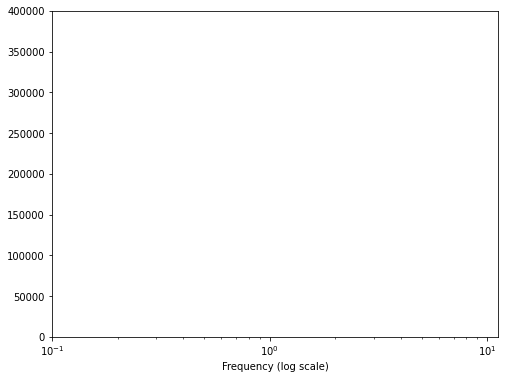

In [48]:

fft = tf.signal.rfft(df_max['S4'])
f_per_dataset = np.arange(0, len(fft))

print(f_per_dataset)
print(np.abs(fft))


n_samples_5min = len(df_max['S4'])
periods_per_day = 12*24
days_per_dataset = n_samples_5min/(periods_per_day)

f_per_day = f_per_dataset/days_per_dataset
print(f_per_day)
plt.step(f_per_day, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
#plt.xticks([1, 24], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

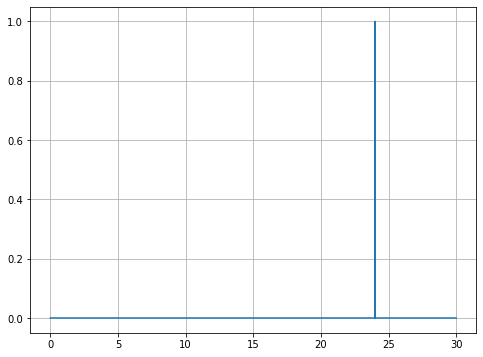

In [170]:
from scipy.fft import fft, fftfreq
# Number of sample points
N = 60*100*5
# sample spacing
T = 1.0 / 60.0
x = np.linspace(0.0, N*T, N, endpoint=False)
y = np.sin(24.0 * 2.0*np.pi*x)
yf = fft(y)
xf = fftfreq(N, T)[:N//2]
import matplotlib.pyplot as plt
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.show()

(0.1, 157.5)

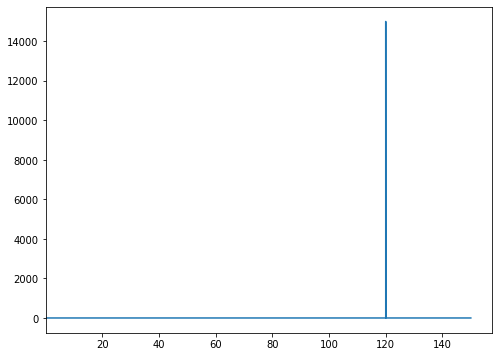

In [171]:

fft = tf.signal.rfft(y)
f_per_dataset = np.arange(0, len(fft))



plt.step(f_per_dataset/100, np.abs(fft))
#plt.xscale('log')

plt.xlim([0.1, max(plt.xlim())])
#plt.xticks([1, 24], labels=['1/day', '1/5hour'])
#_ = plt.xlabel('Frequency (log scale)')

## División de datos

Usaremos una división (70%, 20%, 10%) para los conjuntos de entrenamiento, validación y prueba. Tenga en cuenta que los datos no se mezclan aleatoriamente antes de dividirlos. Esto es por dos razones.

 

1.   Garantiza que aún sea posible dividir los datos en ventanas de muestras consecutivas.
2.   Garantiza que los resultados de la validación / prueba sean más realistas y se evalúen en función de los datos recopilados después de que se entrenara el modelo.




In [ ]:
df1=df
df=df.drop(['date_time'],axis=1)
df.head()

,PRN,S4,Pro-x,Pro-y,Day sin,Day cos,Year sin,Year cos
0,3,0.10,0.213777,-0.357196,0.0016,0.999999,-0.861636,0.507527
1,8,0.05,-0.691644,-0.244924,0.0016,0.999999,-0.861636,0.507527
2,10,0.40,-0.207385,0.134164,0.0016,0.999999,-0.861636,0.507527
3,11,0.08,-0.380023,-0.224745,0.0016,0.999999,-0.861636,0.507527
4,16,0.04,0.641509,-0.203499,0.0016,0.999999,-0.861636,0.507527


In [ ]:
from sklearn.model_selection import train_test_split

column_indices = {name: i for i, name in enumerate(df.columns)}

#y=df['S4']
#X=df[['PRN','Pro-x','Pro-y','Day sin']]
n = len(df)

train_df, test_df = train_test_split(df, test_size=0.25, random_state=1)

train_df, val_df = train_test_split(train_df, test_size=0.125, random_state=1) # 0.125 x 0.8 = 0.1

num_features = df.shape[1]

## Normalizar los datos

Es importante escalar características antes de entrenar una red neuronal. La normalización es una forma común de realizar esta escala. Reste la media y divida por la desviación estándar de cada característica.

La media y la desviación estándar solo deben calcularse utilizando los datos de entrenamiento para que los modelos no tengan acceso a los valores en los conjuntos de validación y prueba.

También se puede argumentar que el modelo no debería tener acceso a valores futuros en el conjunto de entrenamiento durante el entrenamiento, y que esta normalización debería realizarse utilizando promedios móviles. Ese no es el enfoque de este tutorial, y los conjuntos de validación y prueba garantizan que obtenga métricas (algo) honestas. Entonces, en aras de la simplicidad, este tutorial utiliza un promedio simple.

In [ ]:
sklearn.preprocessing.scale(X, *, axis=0, with_mean=True, with_std=True, copy=True)

In [ ]:
#No usamos el modulo de sklearn, debido a que nos da un ouput numpy y tendríamos que reconstruir nuestro dataframe

train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

Ahora analicemos a la distribución de las funciones.

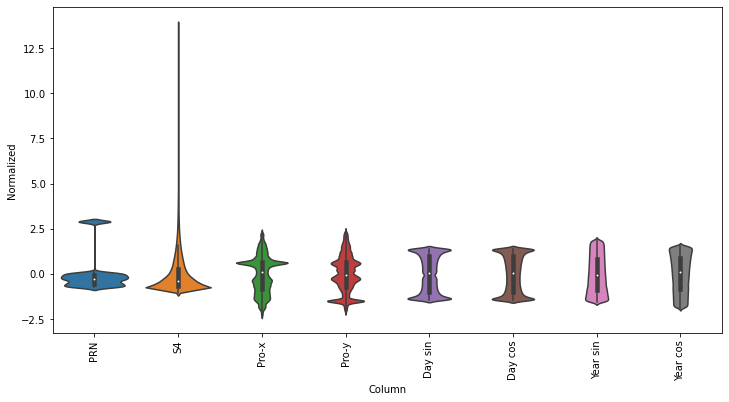

In [ ]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

##Ventana de datos

Los modelos de este tutorial harán un conjunto de predicciones basadas en una ventana de muestras consecutivas de los datos.

Las principales características de las ventanas de entrada son:

*   El ancho (número de pasos de tiempo) de las ventanas de entrada y etiqueta
*   El tiempo de compensación entre ellos.
*   Qué características se utilizan como entradas, etiquetas o ambas.
Este tutorial crea una variedad de modelos (incluidos los modelos Linear, DNN, CNN y RNN) y los usa para ambos:

*   Predicciones de salida única y salida múltiple .
*   Predicciones de paso de tiempo único y paso de tiempo múltiple .
Esta sección se centra en la implementación de la ventana de datos para que pueda reutilizarse para todos esos modelos.

Dependiendo de la tarea y el tipo de modelo, es posible que desee generar una variedad de ventanas de datos. Aquí hay unos ejemplos:

1.   Por ejemplo, para hacer una única predicción 24 horas en el futuro, dadas 24 horas de historial, puede definir una ventana como esta:

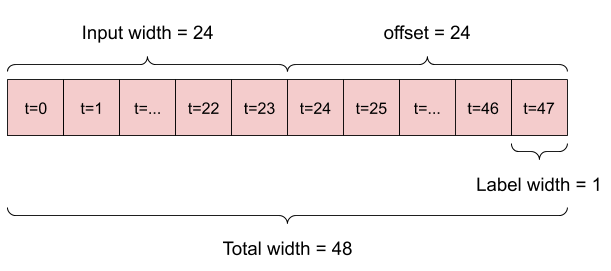

2.   Un modelo que hace una predicción 1h en el futuro, dadas 6h de historia, necesitaría una ventana como esta:

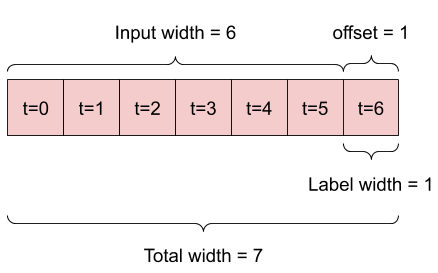

El resto de esta sección define una clase WindowGenerator . Esta clase puede:

Maneje los índices y compensaciones como se muestra en los diagramas de arriba.
Divida las ventanas de entidades en pares (features, labels) .
Trace el contenido de las ventanas resultantes.
Genere de manera eficiente lotes de estas ventanas a partir de los datos de entrenamiento, evaluación y prueba, utilizando [tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) s.

###1. Índices y compensaciones

Empiece creando la clase WindowGenerator . El método __init__ incluye toda la lógica necesaria para los índices de entrada y etiqueta.

También toma los marcos de datos de entrenamiento, evaluación y prueba como entrada. Estos se convertirán a [tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) s de Windows más adelante.

In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

Aquí hay un código para crear las 2 ventanas que se muestran en los diagramas al comienzo de esta sección:

In [ ]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['S4'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['S4']

In [ ]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['S4'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['S4']

###2. Dividir

Dada una lista de entradas consecutivas, el método split_window convertirá en una ventana de entradas y una ventana de etiquetas.

El ejemplo w2 , arriba, se dividirá así:

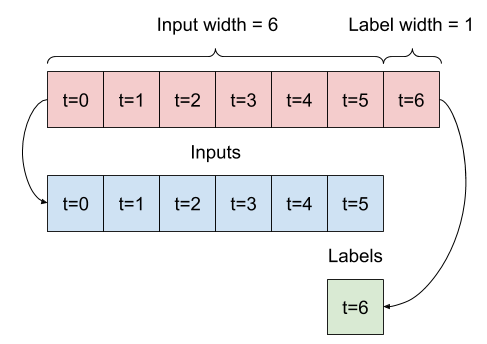

Este diagrama no muestra el eje de features de los datos, pero esta función split_window también maneja label_columns para que pueda usarse tanto para los ejemplos de salida única como para los de múltiples salidas.

In [ ]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

Pruébalo:

In [ ]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])


example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 8)
Inputs shape: (3, 6, 8)
labels shape: (3, 1, 1)


Por lo general, los datos en TensorFlow se empaquetan en arreglos donde el índice más externo está en los ejemplos (la dimensión "lote"). Los índices intermedios son las dimensiones de "tiempo" o "espacio" (ancho, alto). Los índices más internos son las características.

El código anterior tomó un lote de 3 ventanas de 7 pasos de tiempo, con 8 funciones en cada paso de tiempo. Los dividió en un lote de 8 pasos de tiempo, 6 entradas de funciones y una etiqueta de 1 paso de tiempo y 1 función. La etiqueta solo tiene una característica porque WindowGenerator se inicializó con label_columns=['S4'] . Inicialmente, este tutorial creará modelos que predicen etiquetas de salida únicas.

###3. Parcela

Aquí hay un método de trazado que permite una visualización simple de la ventana dividida:

In [ ]:
w2.example = example_inputs, example_labels

In [ ]:
def plot(self, model=None, plot_col='S4', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

Este gráfico alinea las entradas, las etiquetas y las predicciones (posteriores) en función del tiempo al que se refiere el elemento:

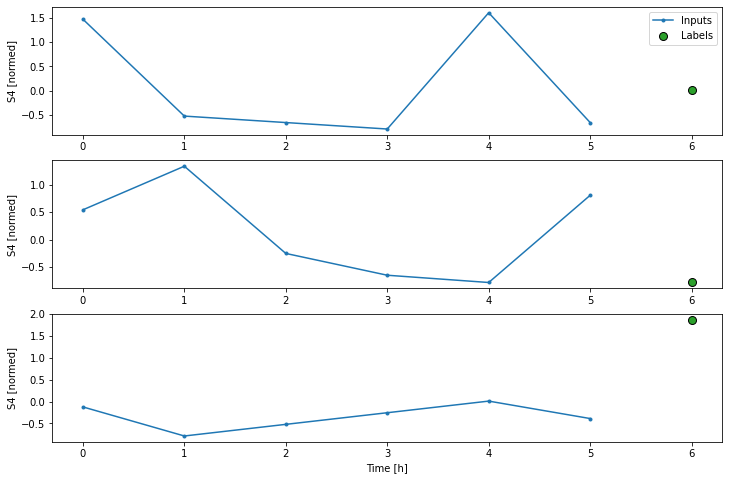

In [ ]:
w2.plot()

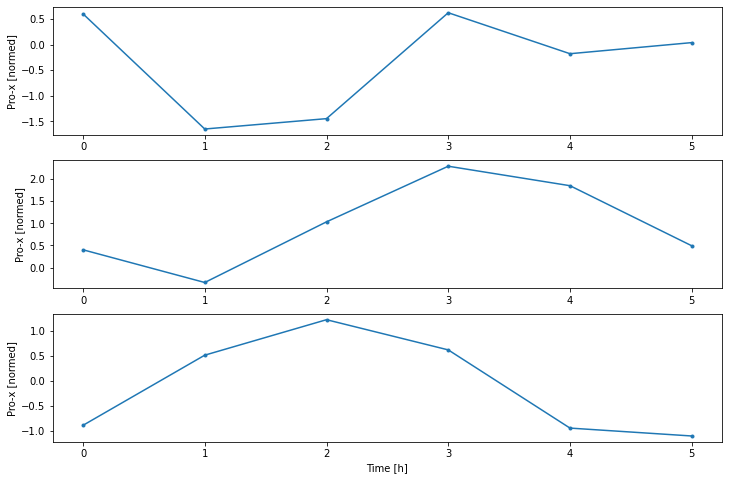

In [ ]:
w2.plot(plot_col='Pro-x')

###4. Cree tf.data.Dataset s

Finalmente, este método make_dataset tomará un DataFrame serie DataFrame y lo convertirá en un [tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) de (input_window, label_window) usando la función [preprocessing.timeseries_dataset_from_array](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/timeseries_dataset_from_array) .

In [ ]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

El objeto WindowGenerator contiene datos de entrenamiento, validación y prueba. Agregue propiedades para acceder a ellas como tf.data.Datasets usando el método make_dataset anterior. También agregue un lote de ejemplo estándar para facilitar el acceso y el trazado:

In [ ]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

Ahora, el objeto WindowGenerator le da acceso a los objetostf.data.Dataset , para que pueda iterar fácilmente sobre los datos.

La propiedad Dataset.element_spec te dice la estructura, los dtypes y las formas de los elementos del conjunto de datos.

In [ ]:
# Each element is an (inputs, label) pair
w2.train.element_spec

(TensorSpec(shape=(None, 6, 8), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

La iteración sobre un Dataset produce lotes concretos:

In [ ]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 8)
Labels shape (batch, time, features): (32, 1, 1)


##Modelos de un solo paso

El modelo más simple que puede construir a partir de este tipo de datos es uno que predice el valor de una sola característica, 1 paso de tiempo (1h) en el futuro basado solo en las condiciones actuales.

Así que comience por construir modelos para predecir el valor de S4 1h en el futuro.

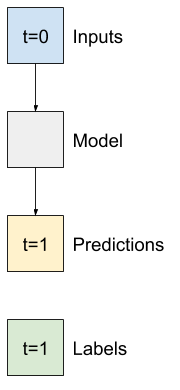

Configure un objeto WindowGenerator para producir estos pares de un solo paso (input, label) :

In [ ]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['S4'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['S4']

El objeto de window crea tf.data.Datasets partir de los conjuntos de entrenamiento, validación y prueba, lo que le permite iterar fácilmente sobre lotes de datos.

In [ ]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 8)
Labels shape (batch, time, features): (32, 1, 1)


###Base

Antes de construir un modelo entrenable, sería bueno tener una línea de base de rendimiento como punto de comparación con los modelos posteriores más complicados.

Esta primera tarea consiste en predecir la temperatura 1h en el futuro dado el valor actual de todas las características. Los valores actuales incluyen la temperatura actual.

Así que comience con un modelo que simplemente devuelva la temperatura actual como predicción, prediciendo "Sin cambios". Esta es una línea de base razonable ya que la temperatura cambia lentamente. Por supuesto, esta línea de base no funcionará tan bien si realiza una predicción adicional en el futuro.

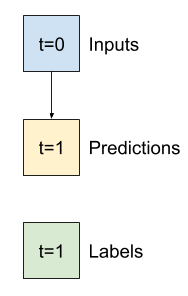

In [ ]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

Cree una instancia y evalúe este modelo:

In [ ]:
baseline = Baseline(label_index=column_indices['S4'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

1328/1328 [==============================] - 4s 3ms/step - loss: 1.9302 - mean_absolute_error: 0.9505


Eso imprimió algunas métricas de rendimiento, pero esas no le dan una idea de qué tan bien está funcionando el modelo.

WindowGenerator tiene un método de gráfico, pero los gráficos no serán muy interesantes con una sola muestra. Por lo tanto, cree un WindowGenerator más WindowGenerator que genere ventanas de 24 horas de entradas y etiquetas consecutivas a la vez.

wide_window no cambia la forma en que opera el modelo. El modelo todavía hace predicciones 1h en el futuro basadas en un solo paso de tiempo de entrada. Aquí, el eje de time actúa como el eje de batch : cada predicción se realiza de forma independiente sin interacción entre los pasos de tiempo.

In [ ]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['S4'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['S4']

Esta ventana expandida se puede pasar directamente al mismo modelo de baseline sin ningún cambio de código. Esto es posible porque las entradas y etiquetas tienen el mismo número de pasos de tiempo, y la línea de base simplemente reenvía la entrada a la salida:

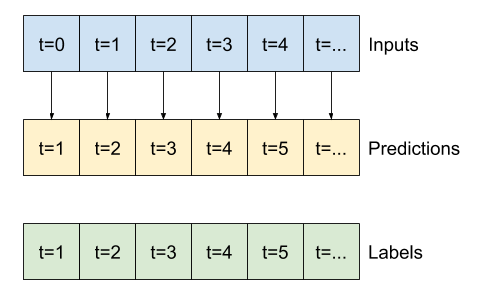

In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 8)
Output shape: (32, 24, 1)


Al trazar las predicciones del modelo de línea de base, puede ver que son simplemente las etiquetas, desplazadas a la derecha en 1h.

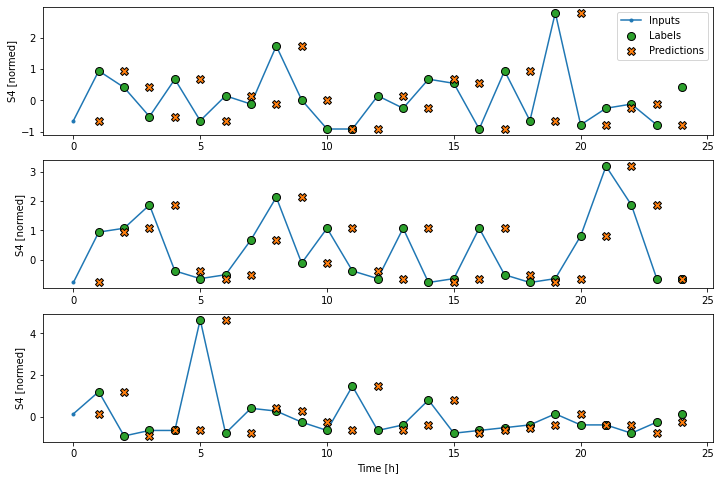

In [ ]:
wide_window.plot(baseline)

En los gráficos anteriores de tres ejemplos, el modelo de un solo paso se ejecuta en el transcurso de 24 h. Esto merece alguna explicación:

*   La línea azul "Entradas" muestra la temperatura de entrada en cada paso de tiempo. El modelo recibe todas las características, este gráfico solo muestra la temperatura.
*   Los puntos verdes de "Etiquetas" muestran el valor de predicción objetivo. Estos puntos se muestran en el momento de la predicción, no en el momento de la entrada. Es por eso que el rango de etiquetas se desplaza 1 paso con respecto a las entradas.
*   Las cruces naranjas de "Predicciones" son las predicciones del modelo para cada paso de tiempo de salida. Si el modelo estuviera prediciendo perfectamente, las predicciones aterrizarían directamente en las "etiquetas".

###Modelo lineal

El modelo entrenable más simple que puede aplicar a esta tarea es insertar una transformación lineal entre la entrada y la salida. En este caso, la salida de un paso de tiempo solo depende de ese paso:



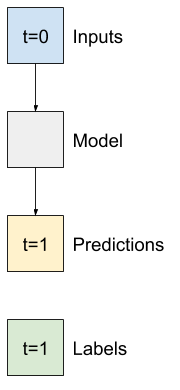





layers.Dense A. layers.Dense sin conjunto de activation es un modelo lineal. La capa solo transforma el último eje de los datos de (batch, time, inputs) a (batch, time, units) , se aplica de forma independiente a cada elemento en los ejes de batch y time .

In [ ]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [ ]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 8)
Output shape: (32, 1, 1)


Este tutorial entrena muchos modelos, así que empaquete el procedimiento de entrenamiento en una función:

In [ ]:
MAX_EPOCHS =5

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

Entrene el modelo y evalúe su desempeño:

In [ ]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/5
9290/9290 [==============================] - 34s 4ms/step - loss: 0.9970 - mean_absolute_error: 0.7286 - val_loss: 0.9893 - val_mean_absolute_error: 0.7265
Epoch 2/5
9290/9290 [==============================] - 34s 4ms/step - loss: 0.9972 - mean_absolute_error: 0.7292 - val_loss: 0.9893 - val_mean_absolute_error: 0.7268
Epoch 3/5
9290/9290 [==============================] - 33s 3ms/step - loss: 0.9971 - mean_absolute_error: 0.7291 - val_loss: 0.9893 - val_mean_absolute_error: 0.7268
Epoch 4/5
9290/9290 [==============================] - 33s 4ms/step - loss: 0.9965 - mean_absolute_error: 0.7289 - val_loss: 0.9892 - val_mean_absolute_error: 0.7271
Epoch 5/5
1328/1328 [==============================] - 4s 3ms/step - loss: 0.9893 - mean_absolute_error: 0.7266


Al igual que el modelo de baseline , el modelo lineal se puede llamar en lotes de ventanas amplias. Usado de esta manera, el modelo hace un conjunto de predicciones independientes en pasos de tiempo consecutivos. El eje de time actúa como otro eje de batch . No hay interacciones entre las predicciones en cada paso de tiempo.

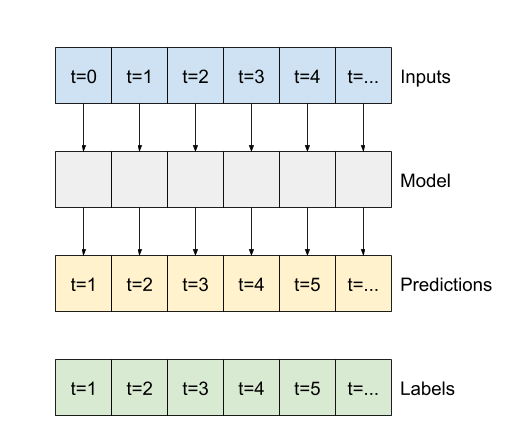

In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 8)
Output shape: (32, 24, 1)


Aquí está la gráfica de sus predicciones de ejemplo en wide_window , observe cómo en muchos casos la predicción es claramente mejor que solo devolver la temperatura de entrada, pero en algunos casos es peor:

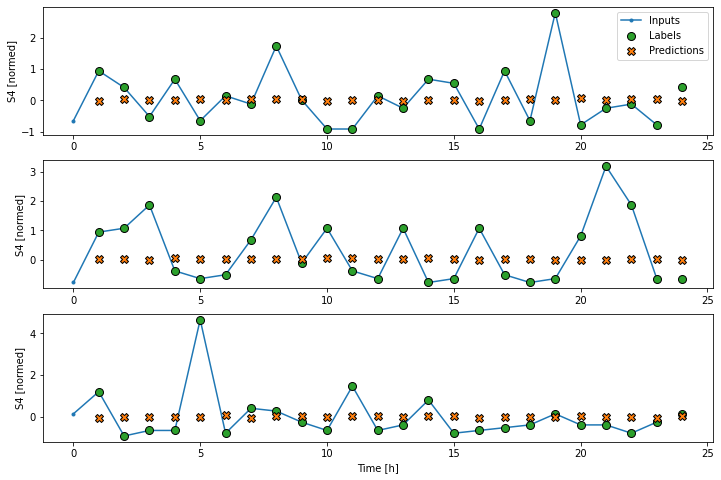

In [ ]:
wide_window.plot(linear)

Una ventaja de los modelos lineales es que son relativamente simples de interpretar. Puede extraer los pesos de la capa y ver el peso asignado a cada entrada:

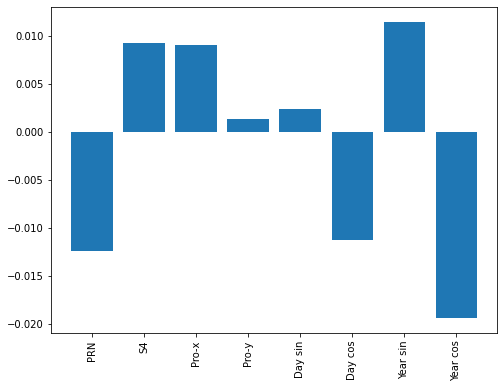

In [ ]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

A veces, el modelo ni siquiera pone el mayor peso en la entrada T (degC) . Este es uno de los riesgos de la inicialización aleatoria.

###Denso

Antes de aplicar modelos que realmente operan en múltiples pasos de tiempo, vale la pena verificar el rendimiento de modelos de pasos de entrada únicos más profundos y potentes.

Aquí hay un modelo similar al modelo linear , excepto que apila varias capas Dense entre la entrada y la salida:

In [ ]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/5
9290/9290 [==============================] - 38s 4ms/step - loss: 1.0131 - mean_absolute_error: 0.7328 - val_loss: 0.9889 - val_mean_absolute_error: 0.7202
Epoch 2/5
9290/9290 [==============================] - 39s 4ms/step - loss: 1.0074 - mean_absolute_error: 0.7297 - val_loss: 0.9888 - val_mean_absolute_error: 0.7197
Epoch 3/5
9290/9290 [==============================] - 39s 4ms/step - loss: 1.0067 - mean_absolute_error: 0.7295 - val_loss: 0.9890 - val_mean_absolute_error: 0.7195
Epoch 4/5
1328/1328 [==============================] - 5s 3ms/step - loss: 0.9889 - mean_absolute_error: 0.7190


###Denso de varios pasos

Un modelo de paso de tiempo único no tiene contexto para los valores actuales de sus entradas. No puede ver cómo cambian las características de entrada con el tiempo. Para abordar este problema, el modelo necesita acceso a múltiples pasos de tiempo al hacer predicciones:

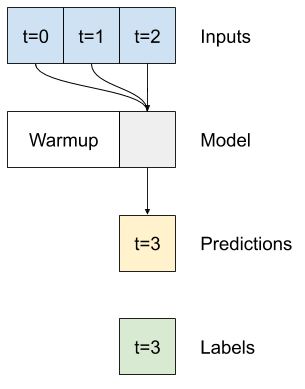

Los modelos de baseline , linear y dense manejaron cada paso de tiempo de forma independiente. Aquí el modelo tomará múltiples pasos de tiempo como entrada para producir una única salida.

Cree un WindowGenerator que producirá lotes de 3 h de entradas y 1h de etiquetas:

Tenga en cuenta que el parámetro de shift la Window es relativo al final de las dos ventanas.

In [ ]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['S4'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['S4']

Text(0.5, 1.0, 'Given 3h as input, predict 1h into the future.')

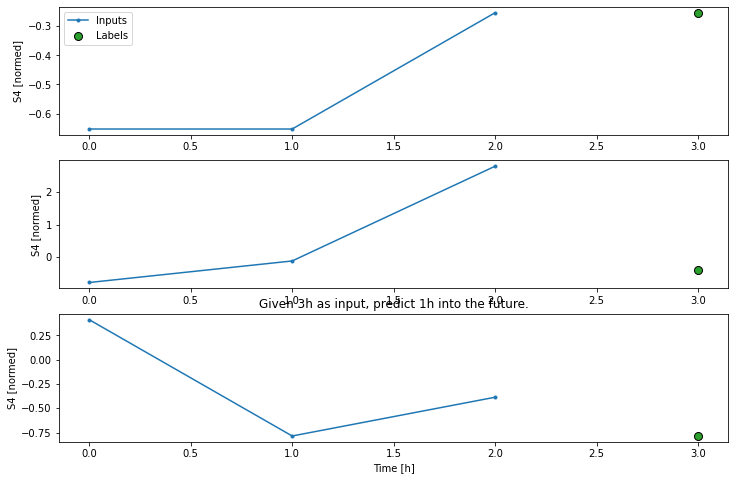

In [ ]:
conv_window.plot()
plt.title("Given 3h as input, predict 1h into the future.")

Puede entrenar un modelo dense en una ventana de pasos de entrada múltiple agregando layers.Flatten como la primera capa del modelo:

In [ ]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [ ]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 8)
Output shape: (32, 1, 1)


In [ ]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

1328/1328 [==============================] - 4s 3ms/step - loss: 0.9895 - mean_absolute_error: 0.7298


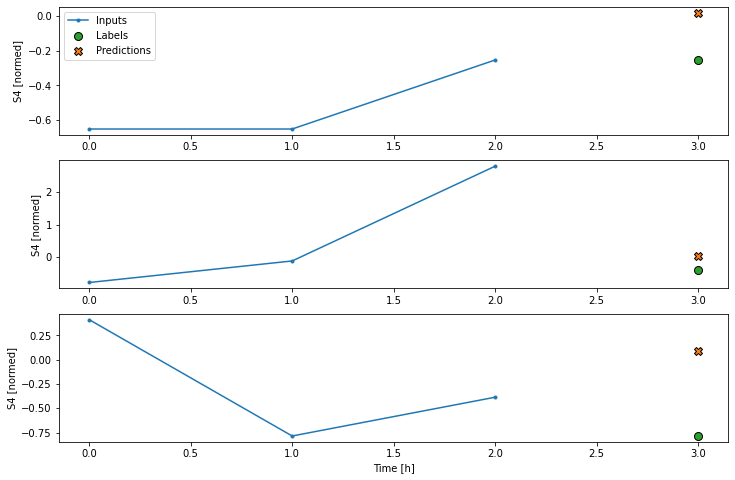

In [ ]:
conv_window.plot(multi_step_dense)

El principal inconveniente de este enfoque es que el modelo resultante solo se puede ejecutar en ventanas de entrada de exactamente esta forma.

In [ ]:
print('Input shape:', wide_window.example[0].shape)
try:
  print('Output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
  print(f'\n{type(e).__name__}:{e}')

Input shape: (32, 24, 8)

ValueError:Input 0 of layer dense_5 is incompatible with the layer: expected axis -1 of input shape to have value 24 but received input with shape (32, 192)


Los modelos convolucionales de la siguiente sección solucionan este problema.

###Red neuronal de convolución

Una capa de convolución ( layers.Conv1D ) también toma varios pasos de tiempo como entrada para cada predicción.

A continuación se muestra el mismo modelo que multi_step_dense , reescrito con una convolución.

Tenga en cuenta los cambios:

*   Las layers.Flatten y las primeras layers.Dense se reemplazan por layers.Conv1D .
*   Las layers.Reshape La layers.Reshape ya no es necesaria ya que la convolución mantiene el eje del tiempo en su salida.

In [ ]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

Ejecútelo en un lote de ejemplo para ver que el modelo produce salidas con la forma esperada:

In [ ]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 8)
Output shape: (32, 1, 1)


conv_window y conv_window en conv_window y debería dar un rendimiento similar al modelo multi_step_dense .

In [ ]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

1328/1328 [==============================] - 4s 3ms/step - loss: 0.9894 - mean_absolute_error: 0.7264


La diferencia entre este conv_model y el modelo multi_step_dense es que conv_model se puede ejecutar en entradas de cualquier longitud. La capa convolucional se aplica a una ventana deslizante de entradas:

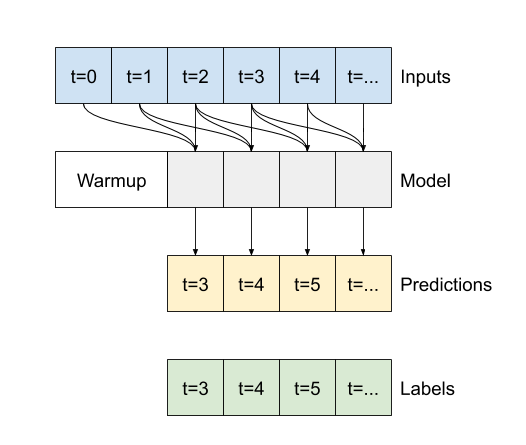

###Red neuronal recurrente

Una red neuronal recurrente (RNN) es un tipo de red neuronal muy adecuada para datos de series de tiempo. Los RNN procesan una serie de tiempo paso a paso, manteniendo un estado interno de paso de tiempo a paso de tiempo.

Para obtener más detalles, lea el tutorial de generación de texto o la guía RNN .

En este tutorial, usará una capa RNN llamada Long Short Term Memory ( LSTM ).

Un argumento de constructor importante para todas las capas de keras RNN es el argumento return_sequences . Esta configuración puede configurar la capa de dos formas.

1.   Si es False , el valor predeterminado, la capa solo devuelve el resultado del paso de tiempo final, lo que le da tiempo al modelo para calentar su estado interno antes de hacer una sola predicción:

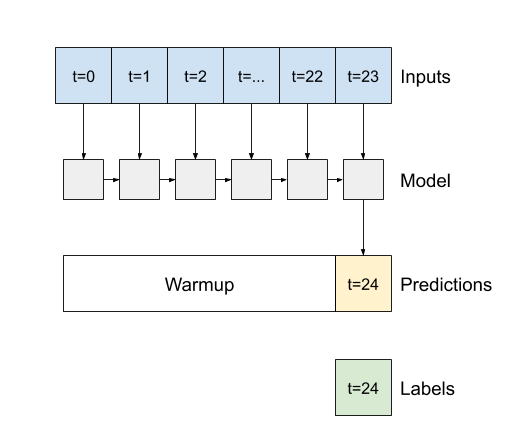

2.   Si es True la capa devuelve una salida para cada entrada. Esto es útil para:
*   Apilamiento de capas RNN.
*   Entrenamiento de un modelo en múltiples pasos de tiempo simultáneamente.

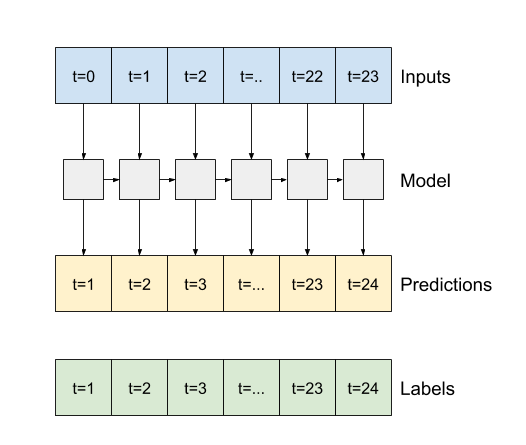

In [ ]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

Con return_sequences=True el modelo se puede entrenar en 24 horas de datos a la vez.

In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 8)
Output shape: (32, 24, 1)


In [ ]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

NameError: ignored

###Actuación

Con este conjunto de datos, cada uno de los modelos funciona ligeramente mejor que el anterior.

In [ ]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [S4, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

NameError: ignored

In [ ]:
S4=df['S4'].values
time = np.arange(S4.size, dtype="float32")
print(time.size)
print(S4.size)

452987
452987
